# Explore here

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix



In [25]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv"
data = pd.read_csv(url)
data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubscribe,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [26]:
data["is_spam"] = data["is_spam"].apply(lambda x: 1 if x else 0).astype(int)
data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubscribe,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


In [27]:
print(data.shape)
print(f"Spam: {len(data.loc[data.is_spam == 1])}")
print(f"No spam: {len(data.loc[data.is_spam == 0])}")

(2999, 2)
Spam: 696
No spam: 2303


Eliminamos los duplicados

In [28]:
data = data.drop_duplicates()
data = data.reset_index(inplace = False, drop = True)
data.shape

(2369, 2)

In [29]:
print(data.shape)
print(f"Spam: {len(data.loc[data.is_spam == 1])}")
print(f"No spam: {len(data.loc[data.is_spam == 0])}")

(2369, 2)
Spam: 244
No spam: 2125


#### Preprocesamiento de URLs (Limpieza básica)  


Dividimos las URLs por signos comunes (/, ., -) para descomponerlas en partes. Esto permite que el modelo identifique patrones dentro de los segmentos de las URLs:

In [30]:
import nltk
print("NLTK está instalado correctamente.")


NLTK está instalado correctamente.


In [31]:


# Descargar las stopwords y el lematizador
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Inicializa el lematizador
lemmatizer = WordNetLemmatizer()

# Cargar stopwords en inglés
stop_words = set(stopwords.words('english'))
print(stop_words)  # Opcional: Ver las stopwords en inglés

#palabras no importantes para quitar
custom_stopwords = {'https', 'http', 'www', 'com', 'html', 'utm', 'p', 'new'}


{'about', "should've", 'here', 'whom', 'during', 'these', 'will', 'should', 't', 'is', "don't", "you'll", 'very', 'further', 'has', 'why', 'then', 'wouldn', "wouldn't", 'it', 'until', 'no', 'won', 'a', 'before', 'out', 'ours', "couldn't", 'from', 'with', 'him', 'ain', 'didn', 'aren', 'own', 'itself', 'themselves', 'm', 'y', 'nor', 'the', 'above', 'off', 'this', 'as', 'after', 'she', "wasn't", 'each', 'my', 'over', 'below', 'our', "hasn't", 've', 'its', 'while', 'now', 'them', 'weren', 'theirs', 'both', 's', "won't", 'doing', 'once', 'did', 'what', "needn't", 'being', 'don', 'do', 'and', 'himself', 'which', 'isn', 'into', 'between', 'up', 'mightn', "shan't", 'through', 'there', 'have', "you'd", 'than', 'of', 'wasn', 'was', 'an', "you've", 'couldn', 'ourselves', 'they', 'hadn', 'who', 'mustn', 'her', 'doesn', 'their', 'some', 'ma', 'you', 'too', 'am', 'more', 'if', 'yourself', 'are', "she's", "weren't", 'we', "mightn't", 'down', 'when', 'those', 'me', 'were', "shouldn't", 'just', 'should

[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/vscode/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [32]:
def preprocess_url(url):  #función para dividir la url en fragmentos
    clean_url = re.sub(r'[^a-zA-Z0-9]', ' ', url.lower()) #busca cualquier cosa que no sea una letra (a-z, A-Z) o número (0-9) - El símbolo ^ dentro de los corchetes indica "todo excepto" - ' ' reemplaza por espacio. Lower minúsculas.
    tokens = clean_url.split() # crea lista con cada espacio que encuentre , dividir palabras o tokenización
    tokens = [word for word in tokens if word not in stop_words] # eliminar las stop_words más comunes del inglés
    tokens = [word for word in tokens if word not in custom_stopwords] #elminar las palabras personalizadas no importantes
    okens = [lemmatizer.lemmatize(word) for word in tokens] #Lematizar cada palabra
    return tokens
    return tokens


In [33]:
# Aplicar la función y ver funcionamiento
data['clean_url'] = data['url'].apply(preprocess_url)

print(data[['url', 'clean_url']].head())

                                                   url  \
0  https://briefingday.us8.list-manage.com/unsubscribe   
1                               https://www.hvper.com/   
2                   https://briefingday.com/m/v4n3i4f3   
3     https://briefingday.com/n/20200618/m#commentform   
4                          https://briefingday.com/fan   

                                       clean_url  
0  [briefingday, us8, list, manage, unsubscribe]  
1                                        [hvper]  
2                        [briefingday, v4n3i4f3]  
3        [briefingday, n, 20200618, commentform]  
4                             [briefingday, fan]  


In [34]:
# Configurar pandas para mostrar todas las columnas y filas completas
pd.set_option('display.max_columns', None)  # Muestra todas las columnas
pd.set_option('display.max_rows', None)     # Muestra todas las filas
pd.set_option('display.max_colwidth', None) # Evita cortar texto en las celdas
# Volver a valores predeterminados
#pd.reset_option('display.max_columns')
#pd.reset_option('display.max_rows')
#pd.reset_option('display.max_colwidth')


In [35]:
data.head(20)

,url,is_spam,clean_url
0,https://briefingday.us8.list-manage.com/unsubscribe,1,"[briefingday, us8, list, manage, unsubscribe]"
1,https://www.hvper.com/,1,[hvper]
2,https://briefingday.com/m/v4n3i4f3,1,"[briefingday, v4n3i4f3]"
3,https://briefingday.com/n/20200618/m#commentform,0,"[briefingday, n, 20200618, commentform]"
4,https://briefingday.com/fan,1,"[briefingday, fan]"
5,https://www.brookings.edu/interactives/reopening-america-and-the-world/,0,"[brookings, edu, interactives, reopening, america, world]"
6,https://www.reuters.com/investigates/special-report/health-coronavirus-britain-pub/,0,"[reuters, investigates, special, report, health, coronavirus, britain, pub]"
7,https://www.theatlantic.com/magazine/archive/2020/07/supermarkets-are-a-miracle/612244/,0,"[theatlantic, magazine, archive, 2020, 07, supermarkets, miracle, 612244]"
8,https://www.vox.com/2020/6/17/21294680/john-bolton-book-excerpts-trump-ukraine-china,0,"[vox, 2020, 6, 17, 21294680, john, bolton, book, excerpts, trump, ukraine, china]"
9,https://www.theguardian.com/travel/2020/jun/18/end-of-tourism-coronavirus-pandemic-travel-industry,0,"[theguardian, travel, 2020, jun, 18, end, tourism, coronavirus, pandemic, travel, industry]"


In [36]:
# Unir todas las listas de tokens en una sola lista
all_words = [word for tokens in data['clean_url'] for word in tokens]

# Obtener palabras únicas
unique_words = set(all_words)
print(f"Número total de palabras únicas: {len(unique_words)}")
print(unique_words)


Número total de palabras únicas: 6812
{'b710', 'nl', 'n1232019', 'blew', 'evenings', 'qualified', '6810841236904217862', 'punish', '8rivqdzh4q4', 'fb', 'fulfills', 'mirror', 'iduskbn2411bx', 'gordon', 'designboom', '737', '6cf116ffe26c', 'standard', 'wirecards', 'blockaloo', 'never', 'boyfriends', 'es', 'allowed', 'washingtonian', 'exsf01', 'jemima', 'justiceforbreonna', '6953481', '400m', 'krakauer', '573fdc2c8bd6', '20200623', 'theverge', 'thecut', 'h1n1', 'suggests', 'charges', 'columbus', 'resume', 'fans', 'macos', 'sephora', 'campaign', '8efb', 'cancels', 'huseman', 'rayshard', 'saharan', '6', '21307528', 'bowman', 'f', 'prove', 'central', 'co', 'imdb', 'sneaks', 'win', 'columns', 'picture', 'mn', 'aww', 'hyped', 'techcommunity', '885127007', '40', 'advertise', 'kaepernick', 'seek', 'b52', 'id1450287953', 'foraging', 'elle', 'puzzle', 'approves', 'abandoned', 'wwdc', 'remodelista', 'masslive', 'pudding', '14', 'nigeria', 'h1b', 'esquire', 'crime', 'webull', 'yedx7xosn76aqw8d0m', '

In [37]:
from collections import Counter

# Contar las palabras
word_counts = Counter(all_words)

# Mostrar las 20 palabras más comunes
word_counts.most_common(20)


[('2020', 794),
 ('06', 542),
 ('news', 272),
 ('us', 222),
 ('coronavirus', 172),
 ('org', 146),
 ('article', 131),
 ('morningbrew', 105),
 ('story', 104),
 ('nytimes', 101),
 ('daily', 99),
 ('6', 96),
 ('stories', 94),
 ('youtube', 89),
 ('trump', 88),
 ('numlock', 87),
 ('watch', 86),
 ('19', 79),
 ('v', 77),
 ('29', 74)]

In [38]:
# Palabras en URLs de spam - zip(data['clean_url'], data['is_spam']): Combina las listas de palabras con sus etiquetas (1 o 0) - if label == 1: Filtra solo las URLs de spam (o no spam con label == 0).
spam_words = [word for tokens, label in zip(data['clean_url'], data['is_spam']) if label == 1 for word in tokens]
spam_word_counts = Counter(spam_words)

# Palabras en URLs de no spam
not_spam_words = [word for tokens, label in zip(data['clean_url'], data['is_spam']) if label == 0 for word in tokens]
not_spam_word_counts = Counter(not_spam_words)

# Mostrar las 10 palabras más comunes en spam y no spam
print("Palabras más comunes en spam:")
print(spam_word_counts.most_common(15))

print("\nPalabras más comunes en no spam:")
print(not_spam_word_counts.most_common(15))


Palabras más comunes en spam:
[('numlock', 86), ('substack', 54), ('sunday', 44), ('manage', 23), ('list', 21), ('morningbrew', 16), ('austinkleon', 12), ('unsubscribe', 11), ('subscribe', 11), ('google', 10), ('daily', 9), ('docs', 9), ('co', 9), ('theskimm', 9), ('us2', 9)]

Palabras más comunes en no spam:
[('2020', 789), ('06', 539), ('news', 272), ('us', 215), ('coronavirus', 168), ('org', 140), ('article', 131), ('story', 104), ('nytimes', 100), ('6', 96), ('stories', 91), ('daily', 90), ('morningbrew', 89), ('trump', 88), ('watch', 85)]


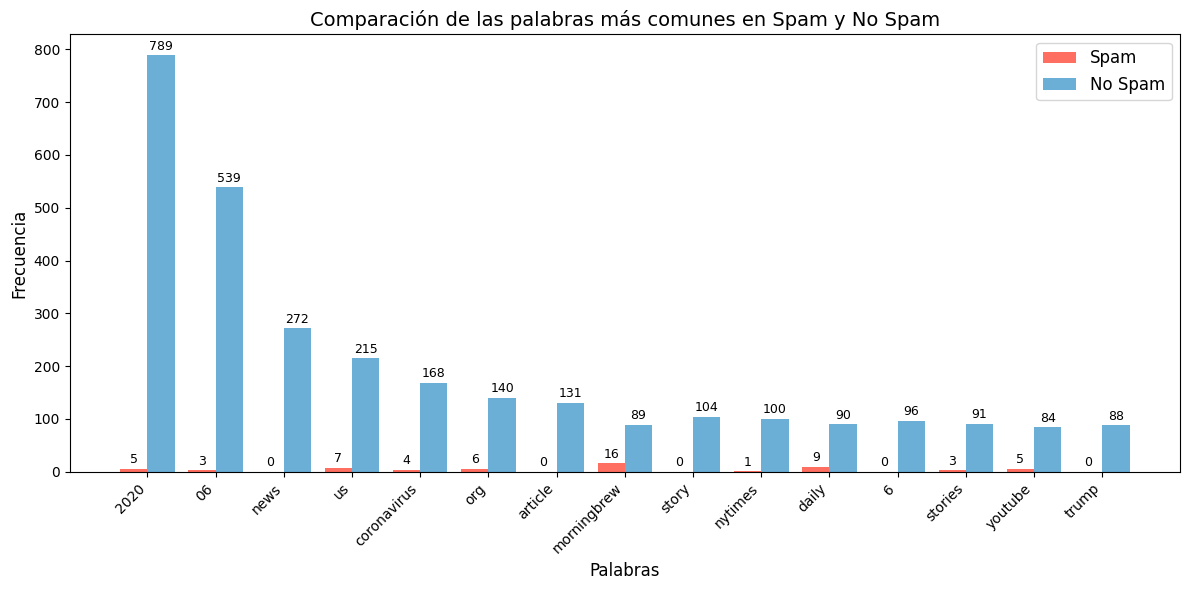

In [39]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Ordenar por frecuencia total
combined_counts = Counter({word: spam_word_counts[word] + not_spam_word_counts[word] for word in all_words})
sorted_words = [word for word, _ in combined_counts.most_common(15)]  # Tomamos solo las 15 palabras más frecuentes

# Obtener frecuencias de palabras en el orden correcto
spam_values = [spam_word_counts[word] for word in sorted_words]
not_spam_values = [not_spam_word_counts[word] for word in sorted_words]

# Configuración del gráfico
x = np.arange(len(sorted_words))  # Posiciones para las palabras
width = 0.4  # Ancho de las barras

fig, ax = plt.subplots(figsize=(12, 6))

# Crear barras para spam y no spam
ax.bar(x - width/2, spam_values, width, label='Spam', color='#FF6F61')
ax.bar(x + width/2, not_spam_values, width, label='No Spam', color='#6BAED6')

# Personalización del gráfico
ax.set_xlabel('Palabras', fontsize=12)
ax.set_ylabel('Frecuencia', fontsize=12)
ax.set_title('Comparación de las palabras más comunes en Spam y No Spam', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(sorted_words, rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=12)

# Añadir valores encima de las barras
for i, (spam, not_spam) in enumerate(zip(spam_values, not_spam_values)):
    ax.text(i - width/2, spam + 5, str(spam), ha='center', va='bottom', fontsize=9, color='black')
    ax.text(i + width/2, not_spam + 5, str(not_spam), ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()


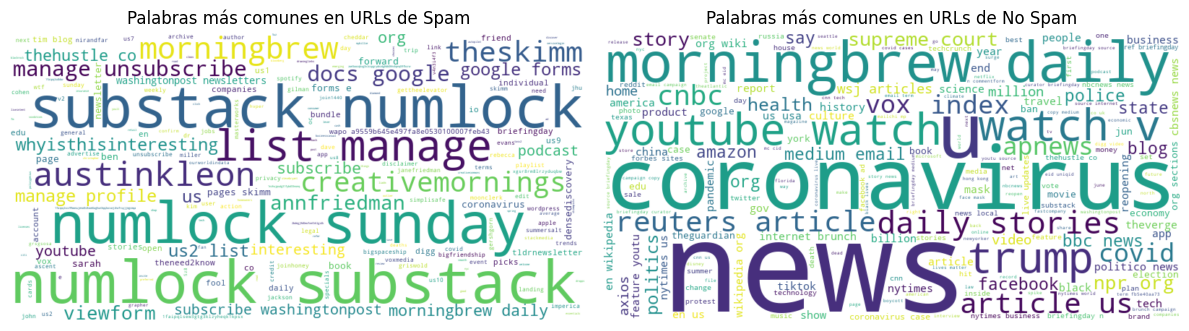

In [40]:
# Generar WordCloud para spam
spam_text = ' '.join([' '.join(tokens) for tokens, label in zip(data['clean_url'], data['is_spam']) if label == 1])
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)

# Generar WordCloud para no spam
not_spam_text = ' '.join([' '.join(tokens) for tokens, label in zip(data['clean_url'], data['is_spam']) if label == 0])
not_spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(not_spam_text)

# Mostrar los WordClouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title("Palabras más comunes en URLs de Spam")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(not_spam_wordcloud, interpolation='bilinear')
plt.title("Palabras más comunes en URLs de No Spam")
plt.axis('off')

plt.tight_layout()
plt.show()


División de los datos

In [41]:
#from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorizar las URLs usando TF-IDF
vectorizer = TfidfVectorizer(max_features=5000) 
X = vectorizer.fit_transform(data['clean_url'].apply(lambda x: ' '.join(x)))  # Une tokens para TF-IDF

# Etiquetas: columna 'is_spam' (1 = spam, 0 = no spam)
y = data['is_spam']



In [42]:
# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imprimir tamaños de los conjuntos
print(f"Tamaño de X_train: {X_train.shape}")
print(f"Tamaño de X_test: {X_test.shape}")


Tamaño de X_train: (1895, 5000)
Tamaño de X_test: (474, 5000)


Entrenamiento del modelo

In [43]:
# from sklearn.svm import SVC
svm_model = SVC()
svm_model.fit(X_train, y_train)

print("El modelo SVM ha sido entrenado con éxito.")


El modelo SVM ha sido entrenado con éxito.


In [44]:
# Hacer predicciones
y_pred = svm_model.predict(X_test)


In [45]:
# from sklearn.metrics import classification_report, confusion_matrix

# Reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       435
           1       0.91      0.51      0.66        39

    accuracy                           0.96       474
   macro avg       0.93      0.75      0.82       474
weighted avg       0.95      0.96      0.95       474

Matriz de Confusión:
[[433   2]
 [ 19  20]]


Interpretación General  

El modelo tiene un excelente desempeño en la clase 0, lo que no es sorprendente, ya que es la clase mayoritaria.  
La clase 1 tiene un recall bajo (51%), lo que indica que el modelo tiene dificultades para identificar correctamente los positivos. Esto podría deberse al desbalance en las clases (435 vs. 39).  
Aunque el accuracy general es alto (96%), la métrica tiende a favorecer la clase dominante.

In [47]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Definir el modelo
svm = SVC()

# Definir los hiperparámetros a buscar
param_grid= {
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "kernel": ["linear", "poly", "rbf", "sigmoid", "precomputed’"],
    "degree": [1, 2, 3, 4, 5],
    "gamma": ["scale", "auto"]
}


# Grid Search
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros
print("Mejores parámetros:", grid_search.best_params_)

# Evaluar el modelo optimizado
y_pred = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))


Mejores parámetros: {'C': 10, 'degree': 1, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       435
           1       0.73      0.69      0.71        39

    accuracy                           0.95       474
   macro avg       0.85      0.83      0.84       474
weighted avg       0.95      0.95      0.95       474



/workspaces/Tutorial-de-Proyecto-de-NLP/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
350 fits failed out of a total of 1750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
350 fits failed with the following error:
Traceback (most recent call last):
  File "/workspaces/Tutorial-de-Proyecto-de-NLP/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/workspaces/Tutorial-de-Proyecto-de-NLP/.venv/lib/python3.10/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/workspaces/Tutorial-de-Proyecto-de-NLP/.venv/lib/python3.10/site-packages/skl

In [48]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Definir el modelo
svm = SVC(C = 1000, degree = 1, gamma = "auto", kernel = "poly", random_state = 42)


# Grid Search
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros
print("Mejores parámetros:", grid_search.best_params_)

# Evaluar el modelo optimizado
y_pred = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))



Mejores parámetros: {'C': 10, 'degree': 1, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       435
           1       0.73      0.69      0.71        39

    accuracy                           0.95       474
   macro avg       0.85      0.83      0.84       474
weighted avg       0.95      0.95      0.95       474



/workspaces/Tutorial-de-Proyecto-de-NLP/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
350 fits failed out of a total of 1750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
350 fits failed with the following error:
Traceback (most recent call last):
  File "/workspaces/Tutorial-de-Proyecto-de-NLP/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/workspaces/Tutorial-de-Proyecto-de-NLP/.venv/lib/python3.10/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/workspaces/Tutorial-de-Proyecto-de-NLP/.venv/lib/python3.10/site-packages/skl

In [49]:
import joblib

# Guardar el modelo optimizado
joblib.dump(grid_search.best_estimator_, '/workspaces/Tutorial-de-Proyecto-de-NLP/srcmodelo_svm_optimizado.pkl')

# Para cargar el modelo en el futuro
modelo_cargado = joblib.load('/workspaces/Tutorial-de-Proyecto-de-NLP/srcmodelo_svm_optimizado.pkl')

# Usar el modelo cargado para predicciones
predicciones = modelo_cargado.predict(X_test)
